In [1]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow import keras # ML
import tensorflow_addons as tfa # TQDM progress bar when training

keras.mixed_precision.set_global_policy('mixed_float16')

BATCH_SIZE = 32

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path # Pathing
from glob import glob # Finding files recursively
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

BASE_DIR = Path("EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla V100-PCIE-32GB, compute capability 7.0


2022-05-27 04:10:35.061628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 04:10:35.100508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 04:10:35.100709: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 04:10:35.134520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Empty                  5797
Morula                 1319
2pn                    1039
Syngamy                 834
4 Cell                  792
2 Cell                  736
Early blast             615
Compacting 8 cell       549
Expanded Blastocyst     394
8 Cell                  384
Blastocyst              374
6 Cell                  360
3 Cell                  303
5 Cell                  130
Name: class, dtype: int64

<AxesSubplot:>

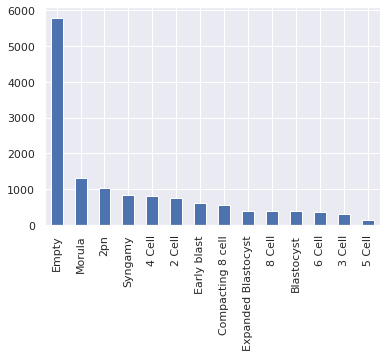

In [2]:
df["class"].value_counts().plot.bar(logy=False)

In [3]:
# Print counts of images by machine and slide
df.filename[~df["class"].isin(["bad", "Empty"])].apply(lambda s: s.split("/")[-1].split("_")[:2]).value_counts()

[M0776, S00512]    1952
[M776, S0087]      1559
[M0776, S00635]    1294
[M0776, S00761]    1138
[M0776, S00534]    1102
[M0776, S00470]     784
Name: filename, dtype: int64

In [4]:
# Track a single embryo's lifecycle
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
# Extract time since fertilisation in minutes from filename (ints, rounded to nearest minute)
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
# Take the earliest time that each class was seen
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                  class  time_since_fert
511                 2pn             1061
685             Syngamy             1464
298              2 Cell             1574
116              3 Cell             2315
104              4 Cell             2395
7                5 Cell             3045
29               6 Cell             3125
145              8 Cell             3265
24    Compacting 8 cell             3375
1169             Morula             4286
373         Early blast             5940
113          Blastocyst             6261
4850              Empty             7036


In [5]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Early blast',
 'Blastocyst',
 'Empty']

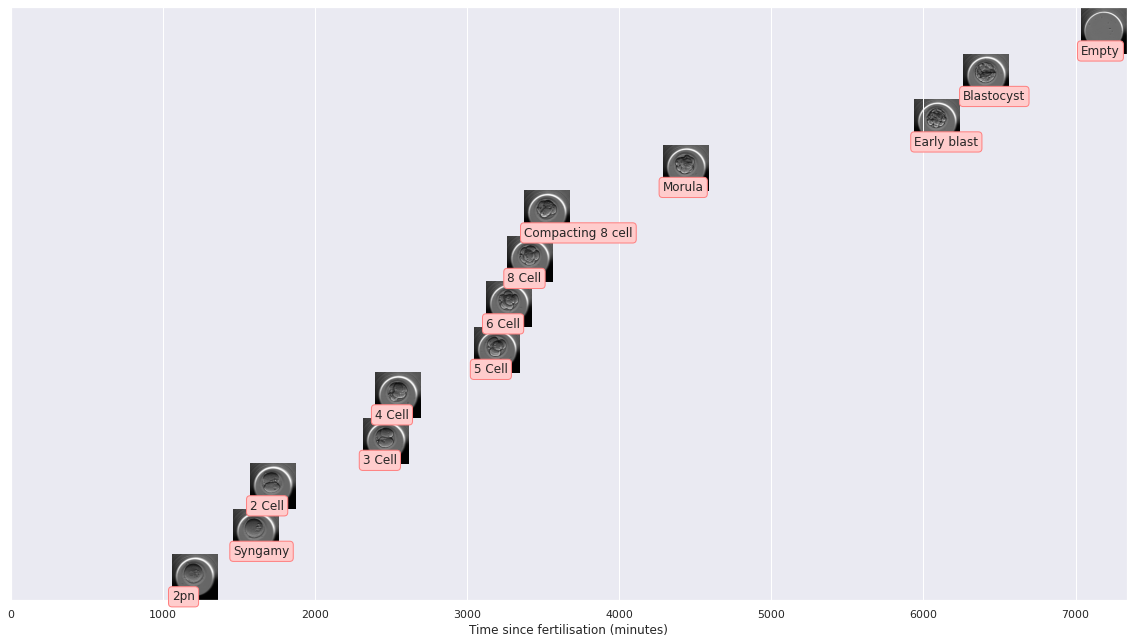

In [6]:
# Plot embryo's lifecycle over time
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

In [7]:
class_counts = df["class"].value_counts()
mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [8]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
# Build training and validation dataframes. This gives us fine control over what we use for train & test
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(min(round(.2*len(df_for_class)), 200))
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        # still leaving 20%. Might need more sophisticated f(x) here for class imbalance.
        train_sample = train_sample.sample(min(len(train_sample), 600))
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00512_W8_F0_6925.jpg,Expanded Blastocyst
1,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00534_W1_F0_7696.jpg,Expanded Blastocyst
2,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00761_W3_F0_6760.jpg,Expanded Blastocyst
3,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00512_W4_F0_6984.jpg,Expanded Blastocyst
4,EmbryoLabeling/Labelers/train/Expanded Blastocyst/M0776_S00761_W2_F0_6620.jpg,Expanded Blastocyst
...,...,...
731,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W3_F0_1654.jpg,2 Cell
732,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00761_W1_F0_2267.jpg,2 Cell
733,EmbryoLabeling/Labelers/train/2 Cell/M776_S0087_W3_F0_1685.jpg,2 Cell
734,EmbryoLabeling/Labelers/train/2 Cell/M0776_S00470_W4_F0_1794.jpg,2 Cell


Syngamy                600
Morula                 600
2pn                    600
4 Cell                 600
Empty                  600
2 Cell                 589
Early blast            492
Compacting 8 cell      439
Expanded Blastocyst    315
8 Cell                 307
Blastocyst             299
6 Cell                 288
3 Cell                 242
5 Cell                 104
Name: class, dtype: int64

2pn                    200
Morula                 200
Empty                  200
Syngamy                167
4 Cell                 158
2 Cell                 147
Early blast            123
Compacting 8 cell      110
Expanded Blastocyst     79
8 Cell                  77
Blastocyst              75
6 Cell                  72
3 Cell                  61
5 Cell                  26
Name: class, dtype: int64

In [9]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=True)
# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)

Found 6075 validated image filenames belonging to 14 classes.
Found 1695 validated image filenames belonging to 14 classes.


In [10]:
assert training.class_indices == validation.class_indices

In [11]:
list(training.class_indices.keys())

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '5 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Compacting 8 cell',
 'Early blast',
 'Empty',
 'Expanded Blastocyst',
 'Morula',
 'Syngamy']

In [12]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '2pn',
 2: '3 Cell',
 3: '4 Cell',
 4: '5 Cell',
 5: '6 Cell',
 6: '8 Cell',
 7: 'Blastocyst',
 8: 'Compacting 8 cell',
 9: 'Early blast',
 10: 'Empty',
 11: 'Expanded Blastocyst',
 12: 'Morula',
 13: 'Syngamy'}

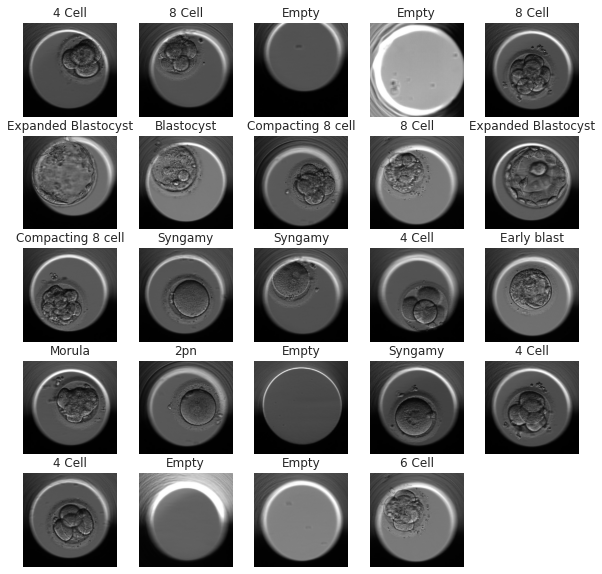

In [13]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

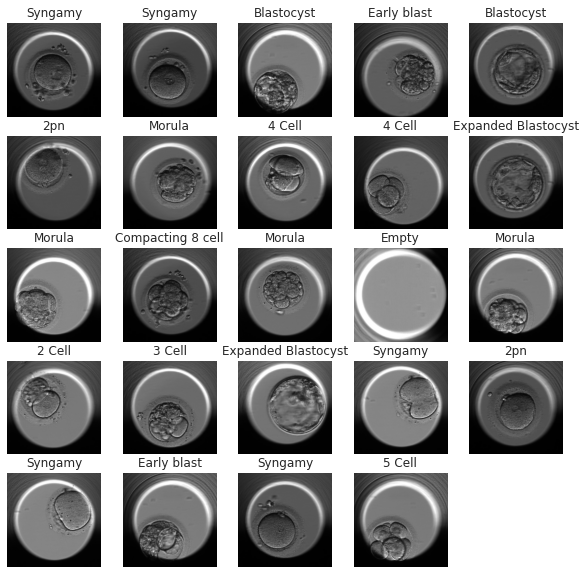

In [14]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [15]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

random_flip = keras.layers.RandomFlip("horizontal_and_vertical")
x = random_flip(inputs)

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=2, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

2022-05-27 04:10:39.700875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-27 04:10:39.702064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 04:10:39.702277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-27 04:10:39.702404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 299, 299, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 14)                28686     
                                                             

In [16]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

history = model.fit(training,
                    epochs=500,
                    verbose=0, # TQDMProgressBar logs out the info, so no need for the default logs
                    validation_data=validation,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1),
                        tfa.callbacks.TQDMProgressBar()
                    ])

Training:   0%|           0/500 ETA: ?s,  ?epochs/s

Epoch 1/500


0/190           ETA: ?s - 

2022-05-27 04:10:46.121357: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2022-05-27 04:10:46.888160: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 2/500


0/190           ETA: ?s - 

Epoch 3/500


0/190           ETA: ?s - 

Epoch 4/500


0/190           ETA: ?s - 

Epoch 5/500


0/190           ETA: ?s - 

Epoch 6/500


0/190           ETA: ?s - 

Epoch 7/500


0/190           ETA: ?s - 

Epoch 8/500


0/190           ETA: ?s - 

Epoch 9/500


0/190           ETA: ?s - 

Epoch 10/500


0/190           ETA: ?s - 

Epoch 11/500


0/190           ETA: ?s - 

Epoch 12/500


0/190           ETA: ?s - 

Epoch 13/500


0/190           ETA: ?s - 

Epoch 14/500


0/190           ETA: ?s - 

Epoch 15/500


0/190           ETA: ?s - 

Epoch 16/500


0/190           ETA: ?s - 

Epoch 17/500


0/190           ETA: ?s - 

Epoch 18/500


0/190           ETA: ?s - 

Epoch 19/500


0/190           ETA: ?s - 

Epoch 20/500


0/190           ETA: ?s - 

Epoch 21/500


0/190           ETA: ?s - 

Epoch 22/500


0/190           ETA: ?s - 

Epoch 23/500


0/190           ETA: ?s - 

Epoch 24/500


0/190           ETA: ?s - 

Epoch 25/500


0/190           ETA: ?s - 

Epoch 26/500


0/190           ETA: ?s - 

Epoch 27/500


0/190           ETA: ?s - 

Epoch 28/500


0/190           ETA: ?s - 

Epoch 29/500


0/190           ETA: ?s - 

Epoch 30/500


0/190           ETA: ?s - 

Epoch 31/500


0/190           ETA: ?s - 

Epoch 32/500


0/190           ETA: ?s - 

Epoch 33/500


0/190           ETA: ?s - 

Epoch 34/500


0/190           ETA: ?s - 

Epoch 35/500


0/190           ETA: ?s - 

Epoch 36/500


0/190           ETA: ?s - 

Epoch 37/500


0/190           ETA: ?s - 

Epoch 38/500


0/190           ETA: ?s - 

Epoch 39/500


0/190           ETA: ?s - 

Epoch 40/500


0/190           ETA: ?s - 

Epoch 41/500


0/190           ETA: ?s - 

Epoch 42/500


0/190           ETA: ?s - 

Epoch 43/500


0/190           ETA: ?s - 

Epoch 44/500


0/190           ETA: ?s - 

Epoch 45/500


0/190           ETA: ?s - 

Epoch 46/500


0/190           ETA: ?s - 

Epoch 47/500


0/190           ETA: ?s - 

Epoch 48/500


0/190           ETA: ?s - 

Epoch 49/500


0/190           ETA: ?s - 

Epoch 50/500


0/190           ETA: ?s - 

Epoch 51/500


0/190           ETA: ?s - 

Epoch 52/500


0/190           ETA: ?s - 

Epoch 53/500


0/190           ETA: ?s - 

Epoch 54/500


0/190           ETA: ?s - 

Epoch 55/500


0/190           ETA: ?s - 

Epoch 56/500


0/190           ETA: ?s - 

Epoch 57/500


0/190           ETA: ?s - 

Epoch 58/500


0/190           ETA: ?s - 

Epoch 59/500


0/190           ETA: ?s - 

Epoch 60/500


0/190           ETA: ?s - 

Epoch 61/500


0/190           ETA: ?s - 

Epoch 62/500


0/190           ETA: ?s - 

Epoch 63/500


0/190           ETA: ?s - 

Epoch 64/500


0/190           ETA: ?s - 

Epoch 65/500


0/190           ETA: ?s - 

Epoch 66/500


0/190           ETA: ?s - 

Epoch 67/500


0/190           ETA: ?s - 

Epoch 68/500


0/190           ETA: ?s - 

Epoch 69/500


0/190           ETA: ?s - 

Epoch 70/500


0/190           ETA: ?s - 

Epoch 71/500


0/190           ETA: ?s - 

Epoch 72/500


0/190           ETA: ?s - 

Epoch 73/500


0/190           ETA: ?s - 

Epoch 74/500


0/190           ETA: ?s - 

Epoch 75/500


0/190           ETA: ?s - 

Epoch 76/500


0/190           ETA: ?s - 

Epoch 77/500


0/190           ETA: ?s - 

Epoch 78/500


0/190           ETA: ?s - 

Epoch 79/500


0/190           ETA: ?s - 

Epoch 80/500


0/190           ETA: ?s - 

Epoch 81/500


0/190           ETA: ?s - 

Epoch 82/500


0/190           ETA: ?s - 

Epoch 83/500


0/190           ETA: ?s - 

Epoch 84/500


0/190           ETA: ?s - 

Epoch 85/500


0/190           ETA: ?s - 

Epoch 86/500


0/190           ETA: ?s - 

Epoch 87/500


0/190           ETA: ?s - 

Epoch 88/500


0/190           ETA: ?s - 

Epoch 89/500


0/190           ETA: ?s - 

Epoch 90/500


0/190           ETA: ?s - 

Epoch 91/500


0/190           ETA: ?s - 

Epoch 92/500


0/190           ETA: ?s - 

Epoch 93/500


0/190           ETA: ?s - 

Epoch 94/500


0/190           ETA: ?s - 

Epoch 95/500


0/190           ETA: ?s - 

Epoch 96/500


0/190           ETA: ?s - 

Epoch 97/500


0/190           ETA: ?s - 

Epoch 98/500


0/190           ETA: ?s - 

Epoch 99/500


0/190           ETA: ?s - 

Epoch 100/500


0/190           ETA: ?s - 

Epoch 101/500


0/190           ETA: ?s - 

Epoch 102/500


0/190           ETA: ?s - 

Epoch 103/500


0/190           ETA: ?s - 

Epoch 104/500


0/190           ETA: ?s - 

Epoch 105/500


0/190           ETA: ?s - 

Epoch 106/500


0/190           ETA: ?s - 

Epoch 107/500


0/190           ETA: ?s - 

Epoch 108/500


0/190           ETA: ?s - 

Epoch 109/500


0/190           ETA: ?s - 

Epoch 110/500


0/190           ETA: ?s - 

Epoch 111/500


0/190           ETA: ?s - 

Epoch 112/500


0/190           ETA: ?s - 

Epoch 113/500


0/190           ETA: ?s - 

Epoch 114/500


0/190           ETA: ?s - 

Epoch 115/500


0/190           ETA: ?s - 

Epoch 116/500


0/190           ETA: ?s - 

Epoch 117/500


0/190           ETA: ?s - 

Epoch 118/500


0/190           ETA: ?s - 

Epoch 119/500


0/190           ETA: ?s - 

Epoch 120/500


0/190           ETA: ?s - 

Epoch 121/500


0/190           ETA: ?s - 

Epoch 122/500


0/190           ETA: ?s - 

Epoch 123/500


0/190           ETA: ?s - 

Epoch 124/500


0/190           ETA: ?s - 

Epoch 125/500


0/190           ETA: ?s - 

Epoch 126/500


0/190           ETA: ?s - 

Epoch 127/500


0/190           ETA: ?s - 

Epoch 128/500


0/190           ETA: ?s - 

Epoch 129/500


0/190           ETA: ?s - 

Epoch 130/500


0/190           ETA: ?s - 

Epoch 131/500


0/190           ETA: ?s - 

Epoch 132/500


0/190           ETA: ?s - 

Epoch 133/500


0/190           ETA: ?s - 

Epoch 134/500


0/190           ETA: ?s - 

Epoch 135/500


0/190           ETA: ?s - 

Epoch 136/500


0/190           ETA: ?s - 

Epoch 137/500


0/190           ETA: ?s - 

Epoch 138/500


0/190           ETA: ?s - 

Epoch 139/500


0/190           ETA: ?s - 

Epoch 140/500


0/190           ETA: ?s - 

Epoch 141/500


0/190           ETA: ?s - 

Epoch 142/500


0/190           ETA: ?s - 

Epoch 143/500


0/190           ETA: ?s - 

Epoch 144/500


0/190           ETA: ?s - 

Epoch 145/500


0/190           ETA: ?s - 

Epoch 146/500


0/190           ETA: ?s - 

Epoch 147/500


0/190           ETA: ?s - 

Epoch 148/500


0/190           ETA: ?s - 

Epoch 149/500


0/190           ETA: ?s - 

Epoch 150/500


0/190           ETA: ?s - 

Epoch 151/500


0/190           ETA: ?s - 

Epoch 152/500


0/190           ETA: ?s - 

Epoch 153/500


0/190           ETA: ?s - 

Epoch 154/500


0/190           ETA: ?s - 

Epoch 155/500


0/190           ETA: ?s - 

Epoch 156/500


0/190           ETA: ?s - 

Epoch 157/500


0/190           ETA: ?s - 

Epoch 158/500


0/190           ETA: ?s - 

Epoch 159/500


0/190           ETA: ?s - 

Epoch 160/500


0/190           ETA: ?s - 

Epoch 161/500


0/190           ETA: ?s - 

Epoch 162/500


0/190           ETA: ?s - 

Epoch 163/500


0/190           ETA: ?s - 

Epoch 164/500


0/190           ETA: ?s - 

Epoch 165/500


0/190           ETA: ?s - 

Epoch 166/500


0/190           ETA: ?s - 

Epoch 167/500


0/190           ETA: ?s - 

Epoch 168/500


0/190           ETA: ?s - 

Epoch 169/500


0/190           ETA: ?s - 

Epoch 170/500


0/190           ETA: ?s - 

Epoch 171/500


0/190           ETA: ?s - 

Epoch 172/500


0/190           ETA: ?s - 

Epoch 173/500


0/190           ETA: ?s - 

Epoch 174/500


0/190           ETA: ?s - 

Epoch 175/500


0/190           ETA: ?s - 

Epoch 176/500


0/190           ETA: ?s - 

Epoch 177/500


0/190           ETA: ?s - 

Epoch 178/500


0/190           ETA: ?s - 

Epoch 179/500


0/190           ETA: ?s - 

Epoch 180/500


0/190           ETA: ?s - 

Epoch 181/500


0/190           ETA: ?s - 

Epoch 182/500


0/190           ETA: ?s - 

Epoch 183/500


0/190           ETA: ?s - 

Epoch 184/500


0/190           ETA: ?s - 

Epoch 185/500


0/190           ETA: ?s - 

Epoch 186/500


0/190           ETA: ?s - 

Epoch 187/500


0/190           ETA: ?s - 

Epoch 188/500


0/190           ETA: ?s - 

Epoch 189/500


0/190           ETA: ?s - 

Epoch 190/500


0/190           ETA: ?s - 

Epoch 191/500


0/190           ETA: ?s - 

Epoch 192/500


0/190           ETA: ?s - 

Epoch 193/500


0/190           ETA: ?s - 

Epoch 194/500


0/190           ETA: ?s - 

Epoch 195/500


0/190           ETA: ?s - 

Epoch 196/500


0/190           ETA: ?s - 

Epoch 197/500


0/190           ETA: ?s - 

Epoch 198/500


0/190           ETA: ?s - 

Epoch 199/500


0/190           ETA: ?s - 

Epoch 200/500


0/190           ETA: ?s - 

Epoch 201/500


0/190           ETA: ?s - 

Epoch 202/500


0/190           ETA: ?s - 

Epoch 203/500


0/190           ETA: ?s - 

Epoch 204/500


0/190           ETA: ?s - 

Epoch 205/500


0/190           ETA: ?s - 

Epoch 206/500


0/190           ETA: ?s - 

Epoch 207/500


0/190           ETA: ?s - 

Epoch 208/500


0/190           ETA: ?s - 

Epoch 209/500


0/190           ETA: ?s - 

Epoch 210/500


0/190           ETA: ?s - 

Epoch 211/500


0/190           ETA: ?s - 

Epoch 212/500


0/190           ETA: ?s - 

Epoch 213/500


0/190           ETA: ?s - 

Epoch 214/500


0/190           ETA: ?s - 

Epoch 215/500


0/190           ETA: ?s - 

Epoch 216/500


0/190           ETA: ?s - 

Epoch 217/500


0/190           ETA: ?s - 

Epoch 218/500


0/190           ETA: ?s - 

Epoch 219/500


0/190           ETA: ?s - 

Epoch 220/500


0/190           ETA: ?s - 

Epoch 221/500


0/190           ETA: ?s - 

Epoch 222/500


0/190           ETA: ?s - 

Epoch 222: early stopping
CPU times: user 2h 22min 43s, sys: 37min 43s, total: 3h 26s
Wall time: 1h 58min 12s


In [17]:
model.save(f"models/{len(code2class)}_class.h5")

<AxesSubplot:>

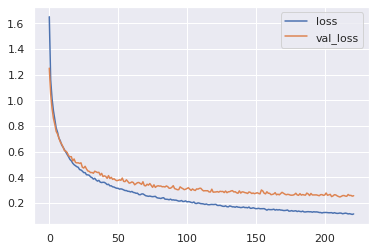

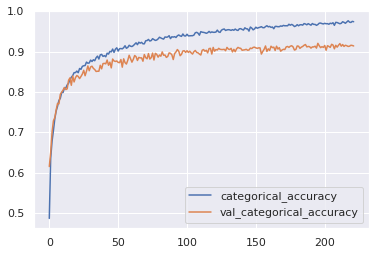

In [18]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [19]:
validation.reset()
print("True:", validation.labels)
print("Predictions: ", model.predict(validation).argmax(axis=1))

True: [13, 13, 7, 9, 7, 1, 12, 3, 3, 11, 12, 8, 12, 10, 12, 0, 2, 11, 13, 1, 13, 9, 13, 4, 0, 12, 13, 1, 0, 12, 7, 3, 13, 3, 12, 12, 0, 12, 12, 13, 12, 6, 12, 9, 0, 11, 12, 0, 10, 1, 1, 9, 1, 8, 10, 13, 10, 6, 1, 12, 6, 6, 13, 1, 0, 3, 13, 11, 3, 12, 6, 10, 1, 9, 1, 10, 10, 3, 11, 3, 8, 13, 3, 10, 1, 9, 2, 1, 13, 12, 10, 3, 5, 8, 0, 8, 6, 1, 12, 13, 0, 11, 6, 12, 10, 1, 10, 1, 1, 11, 2, 10, 3, 13, 12, 0, 12, 2, 6, 13, 13, 3, 5, 0, 10, 3, 10, 0, 7, 3, 10, 12, 8, 1, 10, 2, 10, 0, 12, 8, 10, 9, 11, 3, 11, 0, 9, 12, 8, 10, 1, 11, 7, 0, 7, 3, 9, 6, 12, 12, 6, 12, 5, 7, 2, 1, 12, 9, 1, 10, 10, 3, 10, 13, 12, 3, 8, 12, 10, 10, 8, 13, 10, 0, 1, 12, 10, 8, 6, 7, 2, 10, 1, 0, 12, 12, 11, 13, 6, 13, 13, 0, 3, 7, 10, 12, 2, 3, 10, 5, 1, 13, 1, 7, 3, 8, 13, 13, 8, 2, 0, 7, 13, 0, 7, 7, 5, 13, 0, 13, 12, 8, 13, 8, 9, 8, 1, 3, 10, 9, 5, 13, 0, 1, 12, 11, 9, 8, 9, 3, 5, 12, 7, 10, 3, 11, 1, 5, 6, 3, 0, 10, 5, 9, 13, 10, 8, 13, 0, 0, 2, 8, 3, 1, 3, 9, 7, 9, 10, 0, 5, 8, 6, 3, 10, 0, 13, 5, 1, 7, 10, 5,

In [20]:
y_pred = model.predict(validation)

53/53 [==============================] - 7s 125ms/step


In [40]:
predicted_codes = y_pred.argmax(axis=1)
confidence = y_pred.max(axis=1)
pd.Series(confidence).describe()

count    1695.000000
mean        0.907227
std         0.146240
min         0.282471
25%         0.883057
50%         0.979980
75%         0.998047
max         1.000000
dtype: float64

In [41]:
validation_df["predicted_class"] = [code2class[c] for c in predicted_codes]
validation_df["confidence"] = confidence
validation_df

,filename,class,predicted_class,confidence
446,EmbryoLabeling/Labelers/train/Syngamy/M0776_S00512_W1_F0_1539.jpg,Syngamy,Syngamy,0.948242
131,EmbryoLabeling/Labelers/train/Syngamy/M0776_S00470_W1_F0_2214.jpg,Syngamy,Syngamy,0.995117
38,EmbryoLabeling/Labelers/train/Blastocyst/M776_S0087_W3_F0_8260.jpg,Blastocyst,Blastocyst,0.727051
44,EmbryoLabeling/Labelers/train/Early blast/M0776_S00534_W3_F0_7676.jpg,Early blast,Early blast,0.581543
160,EmbryoLabeling/Labelers/train/Blastocyst/M0776_S00761_W3_F0_6280.jpg,Blastocyst,Blastocyst,0.757324
...,...,...,...,...
453,EmbryoLabeling/Labelers/train/Morula/M0776_S00534_W3_F0_6613.jpg,Morula,Morula,0.955078
286,EmbryoLabeling/Labelers/train/4 Cell/M0776_S00512_W5_F0_2350.jpg,4 Cell,4 Cell,0.992676
567,EmbryoLabeling/Labelers/train/Syngamy/M0776_S00470_W1_F0_1934.jpg,Syngamy,Syngamy,0.984863
186,EmbryoLabeling/Labelers/train/Syngamy/M0776_S00470_W1_F0_2594.jpg,Syngamy,Syngamy,0.999512


In [45]:
validation_df.groupby("class").confidence.median()

class
2 Cell                 0.973145
2pn                    0.993164
3 Cell                 0.958496
4 Cell                 0.985352
5 Cell                 0.796875
6 Cell                 0.804688
8 Cell                 0.918457
Blastocyst             0.893066
Compacting 8 cell      0.846680
Early blast            0.983887
Empty                  1.000000
Expanded Blastocyst    0.987793
Morula                 0.952637
Syngamy                0.993652
Name: confidence, dtype: float16

In [46]:
validation_df.to_csv("validation_predictions.csv", index=False)

                     precision    recall  f1-score   support

             2 Cell       0.95      0.98      0.97       147
                2pn       0.94      0.94      0.94       200
             3 Cell       0.87      0.90      0.89        61
             4 Cell       0.93      0.97      0.95       158
             5 Cell       0.74      0.54      0.62        26
             6 Cell       0.92      0.76      0.83        72
             8 Cell       0.78      0.88      0.83        77
         Blastocyst       0.96      0.69      0.81        75
  Compacting 8 cell       0.87      0.81      0.84       110
        Early blast       0.83      0.91      0.87       123
              Empty       1.00      1.00      1.00       200
Expanded Blastocyst       0.93      0.97      0.95        79
             Morula       0.89      0.93      0.91       200
            Syngamy       0.93      0.93      0.93       167

           accuracy                           0.91      1695
          macro avg   

Text(30.499999999999993, 0.5, 'True')

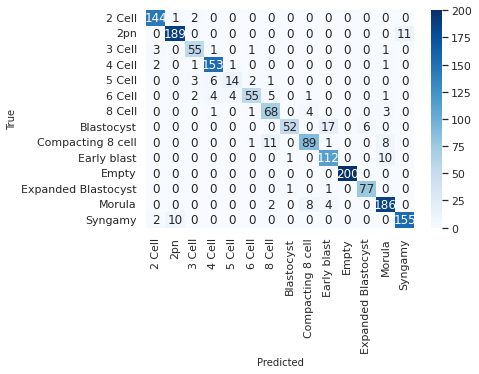

In [47]:
print(classification_report(validation_df["class"], validation_df["predicted_class"]))
labels = list(training.class_indices.keys())
s = sns.heatmap(
    confusion_matrix(validation_df["class"], validation_df["predicted_class"]),
    annot=True,
    cmap='Blues',
    fmt="g",
    xticklabels=labels,
    yticklabels=labels
)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [48]:
# Make some predictions on unlabelled data
folders = os.listdir("EmbryoLabeling/Labelers/One")
folders = [f for f in folders if re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"EmbryoLabeling/Labelers/One/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = "unknown"
    files.append(files_in_folder)
test_df = pd.concat(files)
test_df

,filename,class
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1516.jpg,unknown
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9023.jpg,unknown
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W4_F0_9524.jpg,unknown
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W2_F0_8369.jpg,unknown
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9589.jpg,unknown
...,...,...
4046,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_998.jpg,unknown
4047,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W5_F0_3216.jpg,unknown
4048,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_4793.jpg,unknown
4049,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W3_F0_3916.jpg,unknown


In [49]:
class TQDMPredictCallback(keras.callbacks.Callback):
    def __init__(self, custom_tqdm_instance=None, tqdm_cls=tqdm, **tqdm_params):
        super().__init__()
        self.tqdm_cls = tqdm_cls
        self.tqdm_progress = None
        self.prev_predict_batch = None
        self.custom_tqdm_instance = custom_tqdm_instance
        self.tqdm_params = tqdm_params

    def on_predict_batch_begin(self, batch, logs=None):
        pass

    def on_predict_batch_end(self, batch, logs=None):
        self.tqdm_progress.update(batch - self.prev_predict_batch)
        self.prev_predict_batch = batch

    def on_predict_begin(self, logs=None):
        self.prev_predict_batch = 0
        if self.custom_tqdm_instance:
            self.tqdm_progress = self.custom_tqdm_instance
            return

        total = self.params.get('steps')
        if total:
            total -= 1

        self.tqdm_progress = self.tqdm_cls(total=total, **self.tqdm_params)

    def on_predict_end(self, logs=None):
        if self.tqdm_progress and not self.custom_tqdm_instance:
            self.tqdm_progress.close()

test = datagen.flow_from_dataframe(test_df, target_size=(299, 299), batch_size=BATCH_SIZE, shuffle=False)
results = model.predict(test, callbacks=[TQDMPredictCallback()])

Found 26557 validated image filenames belonging to 1 classes.


  0%|          | 0/829 [00:00<?, ?it/s]

830/830 [==============================] - 111s 134ms/step


In [50]:
predicted_codes = results.argmax(axis=1)
confidence = results.max(axis=1)
pd.Series(confidence).describe()

count    26557.000000
mean         0.816895
std          0.190674
min          0.171753
25%          0.672852
50%          0.893555
75%          0.985352
max          1.000000
dtype: float64

In [51]:
test_df["class"] = [code2class[c] for c in predicted_codes]
test_df["confidence"] = confidence

In [52]:
test_df["class"].value_counts()

2pn                    9054
Syngamy                3302
Early blast            2430
Expanded Blastocyst    2137
Compacting 8 cell      2068
Morula                 1678
Blastocyst             1356
Empty                  1286
5 Cell                  949
4 Cell                  917
2 Cell                  548
8 Cell                  417
3 Cell                  230
6 Cell                  185
Name: class, dtype: int64

In [53]:
test_df.confidence[test_df["class"] == "Empty"].describe()

count    1286.000000
mean        0.924805
std         0.136597
min         0.306885
25%         0.915894
50%         0.997803
75%         1.000000
max         1.000000
Name: confidence, dtype: float64

In [54]:
test_df

,filename,class,confidence
0,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W1_F0_1516.jpg,Syngamy,0.581543
1,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9023.jpg,Morula,0.601074
2,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W4_F0_9524.jpg,Expanded Blastocyst,0.932129
3,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W2_F0_8369.jpg,5 Cell,0.563965
4,EmbryoLabeling/Labelers/One/M3169_S00470/M3169_S00470_W7_F0_9589.jpg,Morula,0.532715
...,...,...,...
4046,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_998.jpg,2pn,1.000000
4047,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W5_F0_3216.jpg,Early blast,0.317383
4048,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W12_F0_4793.jpg,Early blast,0.538086
4049,EmbryoLabeling/Labelers/One/M0831_S00534/M0831_S00534_W3_F0_3916.jpg,Compacting 8 cell,0.819336


In [55]:
test_df.to_csv("predictions.csv", index=False)